In [1]:
import os, sys, json
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sys.path.append("..")

In [2]:
# read from json
data = None
figure_name_prefix = "figures/"
# figure_name_suffix = "200m"
# experiment_names = ["200m/eval-harvest-multiprio-200m", "200m/eval-swift-multiprio-200m", "200m/eval-hpcc-multiprio-200m"]

# figure_name_suffix = "ddl-mixed-fat320-40load-incast64"
figure_name_suffix = "fct-multi"
seed_prefixs = [
    "seed1",
    "seed2",
    "seed3",
    "seed4",
    "seed5",
    "seed6",
    "seed7",
    "seed8",
    "seed9",
]

# data_path = "/home/fyxue/Harvest/HarvestCC/output/conext-paper/eval/" + figure_name_suffix + "/"
data_path = "../../../output/prioplus-eurosys25/experiments/fig11/"
experiment_names = [
    "harvest-delay",
    "swift-compensate",
    "nocc-compensate",
    "swift-nocompensate",
    "nocc-nocompensate",
]

misses = {
    "swift-nocompensate": [10],
    "nocc-nocompensate": [1,2,4,6,8,10],
    "harvest-delay": [26, 28, 30, 32, 34, 36, 38, 40],
    "swift-compensate": [26, 28, 30, 32, 34, 36, 38, 40],
    "nocc-compensate": [26, 28, 30, 32, 34, 36, 38, 40],
}

kinds = ["total", "small", "mid", "large"]

In [3]:
slowdowns = [[] for i in range(len(experiment_names))]
avg_slowdowns_all = []
p99_slowdowns_all = []
avg_fct_all = []
p99_fct_all = []
for i in range(len(kinds)):
    avg_slowdowns_all.append([[] for i in range(len(experiment_names))])
    p99_slowdowns_all.append([[] for i in range(len(experiment_names))])
    avg_fct_all.append([[] for i in range(len(experiment_names))])
    p99_fct_all.append([[] for i in range(len(experiment_names))])

for k in range(len(kinds)):
    for i in range(len(seed_prefixs)):
        for j in range(len(experiment_names)):
            avg_slowdowns_all[k][j].append([])
            p99_slowdowns_all[k][j].append([])
            avg_fct_all[k][j].append([])
            p99_fct_all[k][j].append([])

start_idx = 3
rtt = 12e3
for seed_prefix in seed_prefixs:
    seed_idx = int(seed_prefix[-1]) - start_idx
    for exp_idx, experiment_name in enumerate(experiment_names):
        # if not a dir, continue
        if not os.path.isdir(data_path + seed_prefix + '/' + experiment_name + '/'):
            continue
        for file in os.listdir(data_path + seed_prefix + '/' + experiment_name + '/'):
            if file.endswith(".json"):
                file_idx = int(file.split("-")[-1].split(".")[0]) + 1
                if experiment_name in misses and file_idx in misses[experiment_name]:
                    continue
                with open(data_path + seed_prefix + '/' + experiment_name + '/' + file, "r") as f:
                    data = json.load(f)

                flow_slowdowns = [[] for i in range(len(kinds))]
                flow_fcts = [[] for i in range(len(kinds))]

                for flow in data["flowStatistics"]:
                    total_size_bytes = flow["totalSizeBytes"]
                    fct = flow["fctNs"]
                    if total_size_bytes == 0:
                        continue
                    slowdown = fct / (total_size_bytes * 8 / 100e9 * 1e9 + rtt)

                    # flow_idx = int(flow["flowType"].split(" ")[0])
                    # if flow_idx < (file_idx / 2):
                    if total_size_bytes <= 300e3:
                        flow_slowdowns[1].append(slowdown)
                        flow_fcts[1].append(fct)
                    elif total_size_bytes <= 6e6:
                        flow_slowdowns[2].append(slowdown)
                        flow_fcts[2].append(fct)
                    else:
                        flow_slowdowns[3].append(slowdown)
                        flow_fcts[3].append(fct)
                    flow_slowdowns[0].append(slowdown)
                    flow_fcts[0].append(fct)

                # calculate the average slowdown and the p99 slowdowns
                for k in range(len(kinds)):
                    avg_slowdowns_all[k][exp_idx][seed_idx].append([file_idx, np.mean(flow_slowdowns[k])])
                    p99_slowdowns_all[k][exp_idx][seed_idx].append([file_idx, np.percentile(flow_slowdowns[k], 99)])
                    avg_fct_all[k][exp_idx][seed_idx].append([file_idx, np.mean(flow_fcts[k])])
                    p99_fct_all[k][exp_idx][seed_idx].append([file_idx, np.percentile(flow_fcts[k], 99)])

avg_slowdowns = []
avg_fct = []
p99_slowdowns = []
p99_fct = []
for k in range(len(kinds)):
    avg_slowdowns.append([[] for i in range(len(experiment_names))])
    avg_fct.append([[] for i in range(len(experiment_names))])
    p99_slowdowns.append([[] for i in range(len(experiment_names))])
    p99_fct.append([[] for i in range(len(experiment_names))])

# each is mean value of all seed
for k in range(len(kinds)):
    for exp_idx in range(len(experiment_names)):
        avg_slowdowns[k][exp_idx] = np.mean(np.array(avg_slowdowns_all[k][exp_idx]), axis=0)
        avg_fct[k][exp_idx] = np.mean(np.array(avg_fct_all[k][exp_idx]), axis=0)
        p99_slowdowns[k][exp_idx] = np.mean(np.array(p99_slowdowns_all[k][exp_idx]), axis=0)
        p99_fct[k][exp_idx] = np.mean(np.array(p99_fct_all[k][exp_idx]), axis=0)


In [4]:
from pprint import pprint
# print(slowdowns[0].keys())
for k in range(len(kinds)):
    for i in range(len(experiment_names)):
        # print(experiment_names[i])
        # 将avg_slowdowns[i]和p99_slowdowns[i]按照file_idx(即每个元素为一个list，list的第一个值）排序
        avg_slowdowns[k][i] = sorted(avg_slowdowns[k][i], key=lambda x: x[0])
        avg_fct[k][i] = sorted(avg_fct[k][i], key=lambda x: x[0])
        p99_slowdowns[k][i] = sorted(p99_slowdowns[k][i], key=lambda x: x[0])
        p99_fct[k][i] = sorted(p99_fct[k][i], key=lambda x: x[0])

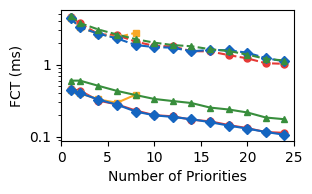

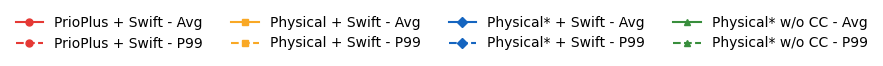

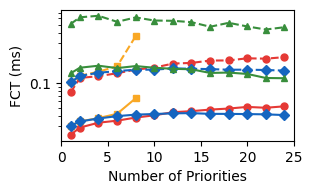

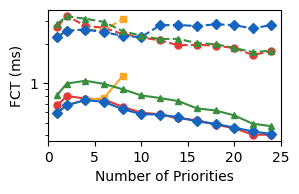

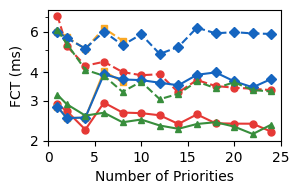

In [5]:
# 依次画total、high、mid、low的fct
# colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
colors = ['#e53935', '#F9A825', '#1565C0', '#388E3C']
# colors = ['#f18181', '#FBC02D', '#2196F3', '#4CAF50']

labels = ["PrioPlus + Swift", "Physical + Swift",
          "Physical* + Swift", "Physical* w/o CC"]
markers = ['o', 's', 'D', '^']
maker_size = 5

exp_index = [0, 3, 1, 2]
fig_names = ['a', 'b', 'c', 'd']
for k in range(len(kinds)):
    fig, axs = plt.subplots(1, 1)
    for i, ei in enumerate(exp_index):
        axs.plot([x[0] for x in avg_fct[k][ei]], [x[1]/1e6 for x in avg_fct[k][ei]],
                 label=labels[i] + " - Avg", color=colors[i], marker=markers[i], markersize=maker_size)
        if k != 4:
            axs.plot([x[0] for x in p99_fct[k][ei]], [x[1]/1e6 for x in p99_fct[k][ei]], label=labels[i] +
                    " - P99", color=colors[i], marker=markers[i], markersize=maker_size, linestyle='dashed')
    axs.set(xlabel='Number of Priorities', ylabel='FCT (ms)')
    axs.label_outer()
    axs.set_yscale('log')
    # axs.set_ylim(1.5e4, 0.8e7)
    # set title
    # axs.set_title(kinds[k])
    axs.set_xlim(0, 25)
    fig.set_size_inches(3, 1.7)
    if (k == 0):
        axs.set_yticks([0.1, 1], ['0.1', '1'])
    if (k == 1):
        axs.set_yticks([0.1], ['0.1'])
    if (k == 2):
        axs.set_yticks([1], ['1'])
    if (k == 3):
        axs.set_yticks([2, 3, 4, 6], ['2', '3', '4', '6'])
    plt.savefig("../figures/fig11" + fig_names[k] + ".pdf", dpi=600, bbox_inches='tight')

    if k == 0:
        fig_legend, ax_legend = plt.subplots(1, 1, figsize=(6, 0.5))
        ax_legend.axis('off')
        # ax_legend.legend(handles = [plt.Line2D([0], [0], color=colors[i], label=labels[i]) for i in range(len(labels))], loc='center', ncol=3)
        ax_legend.legend(*axs.get_legend_handles_labels(),
                         loc='center', ncol=4, frameon=False)
        plt.savefig("../figures/fig11-legend" + ".pdf", dpi=600, bbox_inches='tight')